# Preamble

In [1]:
# load the functionality into Julia
using Plots, StatPlots
using ExcelReaders, FileIO, DataFrames, Query, Distributions, Optim
pyplot()

Plots.PyPlotBackend()

# Loading the data

In [2]:
df = readxlsheet(DataFrame,"Data.xlsx",1) |>
    @query(i, begin
        @select {date=i.Date, i=i.Onset_Dec27}
        end) |> DataFrame
df[:i] = Int64.(df[:i]); df[:date] = DateTime.(df[:date]); df[:t] = 1:nrow(df);
df[:datestring] = Dates.format(df[:date], "u dd");
df |> head

,date,i,t,datestring
1,2017-11-08T00:00:00,1,1,Nov 08
2,2017-11-09T00:00:00,0,2,Nov 09
3,2017-11-10T00:00:00,0,3,Nov 10
4,2017-11-11T00:00:00,0,4,Nov 11
5,2017-11-12T00:00:00,1,5,Nov 12
6,2017-11-13T00:00:00,0,6,Nov 13


In [3]:
# We omit last five datapoints due to the reporting reporting delay
df = df[maximum(df[:t])-df[:t].>=5,:]

,date,i,t,datestring
1,2017-11-08T00:00:00,1,1,Nov 08
2,2017-11-09T00:00:00,0,2,Nov 09
3,2017-11-10T00:00:00,0,3,Nov 10
4,2017-11-11T00:00:00,0,4,Nov 11
5,2017-11-12T00:00:00,1,5,Nov 12
6,2017-11-13T00:00:00,0,6,Nov 13
7,2017-11-14T00:00:00,0,7,Nov 14
8,2017-11-15T00:00:00,1,8,Nov 15
9,2017-11-16T00:00:00,1,9,Nov 16
10,2017-11-17T00:00:00,0,10,Nov 17



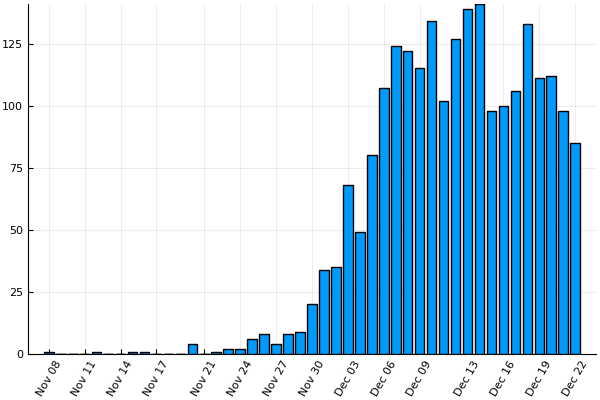

In [4]:
@df df bar(:datestring,:i,legend=false, xrotation=60)

# Generation time

(We assume that no infection before the onset of symptoms, so **generation time = serial interval**)

Distributions.Gamma{Float64}(α=4.0, θ=2.0)


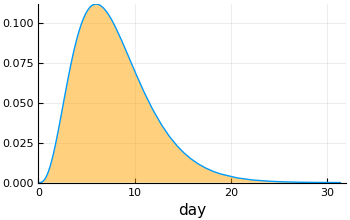

In [5]:
mean_gt = 8.0; # mean = 8 days
CV_gt = 0.5; #CV is 50% 

αgt=1/CV_gt^2; θgt = mean_gt/αgt

gt = Gamma(αgt,θgt)
show(gt)

plot(gt, fill=(0, .5, :orange), size=(350,220), legend=false, xlim=(0,32), xlab="day")


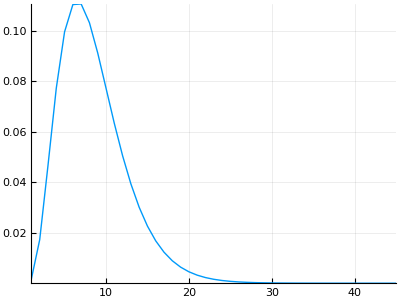

In [6]:
gen_time = (x -> cdf(gt,x)-cdf(gt,x-1)).(1:nrow(df))
plot(gen_time,size=(400,300),legend=false)

In [7]:
quantile.(gt,[.025,.5,.975])

3-element Array{Float64,1}:
  2.17973
  7.34412
 17.5345 

# Latin hypercube sampling

In [8]:
## The function is adopted from:
## https://github.com/robertfeldt/BlackBoxOptim.jl/blob/master/src/utilities/latin_hypercube_sampling.jl
"""
    latin_hypercube_sampling(mins, maxs, numSamples)
    Randomly sample `numSamples` values from the parallelogram defined
    by `mins` and `maxs` using the Latin hypercube algorithm.
"""
function latin_hypercube_sampling{T}(mins::AbstractVector{T}, maxs::AbstractVector{T}, numSamples::Integer)
    dims = length(mins)
    result = zeros(T, numSamples, dims)
    @inbounds for i in 1:dims
        interval_len = (maxs[i] - mins[i]) / numSamples
        result[:,i] = shuffle!(linspace(mins[i], maxs[i] - interval_len, numSamples) +
                               interval_len*rand(numSamples))
    end
    return result'
end

latin_hypercube_sampling

In [9]:
nsamples = 1000

# for reproducibility we fix the seed of the random number generator
srand(7)
smpls = latin_hypercube_sampling([0.0],[1.0],nsamples);

### Vaccination coverage

 * Symmetric triangular distribution


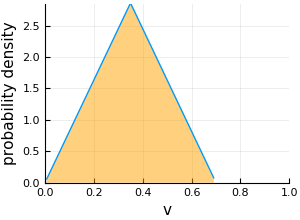

In [10]:
vmin = 0.0
vmax = 0.70
vpeak = (vmax-vmin)/2

vs = quantile.(TriangularDist(vmin,vmax,vpeak),smpls[1,:])
plot(TriangularDist(vmin,vmax,vpeak),legend=false,fill=(0,.5,:orange),size=(300,220),
    xlim=(0,1),xlab="v",ylab="probability density")


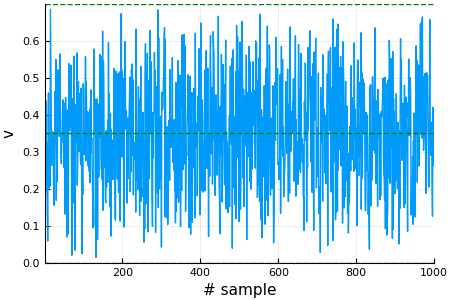

In [11]:
plot(vs,legend=false)
hline!([vmin,vmax,vpeak],line=(:dash, :green),size=(450,300),xlab="# sample",ylab="v")

# Log-likelihood function

In [12]:
N = 579384
println("Effective population size: $(Int64(N))")

Effective population size: 579384


In [13]:
v = (vmax+vmin)/2
kmax = nrow(df)
function getNegativeLoglk(params)
    # Log-exponential transformation of input variables to be sure that they all stay positive for the optimization routine
    R0 = exp(params[1])
    α1 = exp(params[2])
    α2 = exp(params[3])
    α = [[α1 for x in 1:34]; [α2 for x in 35:kmax]]
    loglk = 0
    for k in 2:kmax
        λ = R0*(1-v-sum(df[1:(k-1),:i]./α[1:(k-1)])/N)*α[k]*sum(df[1:(k-1),:i]./α[1:(k-1)].*gen_time[(k-1):-1:1])
        loglk += λ<=0 ? 0 : df[k,:i]*log(λ)-λ
    end
    return(-loglk)
end

getNegativeLoglk(log.([7,.1,.01]))

-7565.503589993599

In [14]:
res0 = optimize(getNegativeLoglk, log.([6,0.1,0.1]))

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [1.791759469228055,-2.3025850929940455, ...]
 * Minimizer: [1.9681226141322927,-4.588687821908185, ...]
 * Minimum: -8.073713e+03
 * Iterations: 112
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 209

In [15]:
res = Optim.minimizer(res0)
exp.(res)

3-element Array{Float64,1}:
 7.15723  
 0.0101662
 0.0052803

### A bit modified function that incorporates some analytical derivation

(We can derive directly $R_0$ as the function $\alpha_1$, $\alpha_2$ and $v$)

In [16]:
v = (vmax+vmin)/2
kmax = nrow(df)
function getNegativeLoglk(params) 
    α1 = exp(params[1])
    α2 = exp(params[2])
    α = [[α1 for x in 1:34]; [α2 for x in 35:kmax]]
    R0numerator = 0.0; R0denominator = 0.0
    for k in 2:kmax
        R0numerator += df[k,:i]
        R0denominator += (1-v-sum(df[1:(k-1),:i]./α[1:(k-1)])/N)*α[k]*sum(df[1:(k-1),:i]./α[1:(k-1)].*gen_time[(k-1):-1:1])
    end
    R0 = R0numerator/R0denominator
    loglk = 0
    for k in 2:kmax
        λ = R0*(1-v-sum(df[1:(k-1),:i]./α[1:(k-1)])/N)*α[k]*sum(df[1:(k-1),:i]./α[1:(k-1)].*gen_time[(k-1):-1:1])
        loglk += λ<=0 ? 0 : df[k,:i]*log(λ)-λ
    end
    return(-loglk)
end

function getR0(params) 
    α1 = exp(params[1])
    α2 = exp(params[2])
    α = [[α1 for x in 1:34]; [α2 for x in 35:kmax]]
    R0numerator = 0.0; R0denominator = 0.0;
    for k in 2:kmax
        R0numerator += df[k,:i]
        R0denominator += (1-v-sum(df[1:(k-1),:i]./α[1:(k-1)])/N)*α[k]*sum(df[1:(k-1),:i]./α[1:(k-1)].*gen_time[(k-1):-1:1])
    end
    
    return(R0numerator/R0denominator)
end

getNegativeLoglk(log.([.1,.1]))

-7598.986560896426

Just checking that we still have the same result as we had before:

In [17]:
res0 = optimize(getNegativeLoglk, log.([.01,.01]))

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [-4.605170185988091,-4.605170185988091]
 * Minimizer: [-4.5886861319200305,-5.243772128532607]
 * Minimum: -8.073713e+03
 * Iterations: 45
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 88

In [18]:
res = Optim.minimizer(res0)
exp.(res)

2-element Array{Float64,1}:
 0.0101662
 0.0052803

In [19]:
R0 = getR0(res)

7.157230132177564

Testing that BFGS() method gives the same result as we just had for Nelder-Mead

In [20]:
res0 = optimize(getNegativeLoglk, log.([.01,.01]), BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [-4.605170185988091,-4.605170185988091]
 * Minimizer: [-4.588686035118337,-5.243772440547911]
 * Minimum: -8.073713e+03
 * Iterations: 9
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 9.11e-12 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = -1.13e-16 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.64e-08 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 37
 * Gradient Calls: 37

# Uncertainty analysis

In [ ]:
R0s = Vector(nsamples)
α1s = Vector(nsamples)
α2s = Vector(nsamples)
initial = [.01, .01]
for k in 1:nsamples
    v = vs[k]
    println(k)
    res0 = optimize(getNegativeLoglk,log.(initial))
    res = Optim.minimizer(res0)
    α = [[exp(res[1]) for x in 1:34]; [exp(res[2]) for x in 35:kmax]]
    if (1-v-sum(df[:i]./α)/N)<=0 
        R0s[k] = -1; α1s[k] = -1; α2s[k] = -1
    else
        R0s[k] = getR0(res)
        α1s[k] = exp(res[1])
        α2s[k] = exp(res[2])
    end
end

### Results: statistics

In [22]:
dfResults = DataFrame(v = Float64.(vs), R0 = Float64.(R0s), α2 = Float64.(α2s), α1 = Float64.(α1s))
dfResults |> head

,v,R0,α2,α1
1,0.5894227250213706,11.330879490025549,0.008359434026414361,0.01609451073570251
2,0.10538829771244006,5.200247755484328,0.0038365168855488906,0.00738649045719166
3,0.43856148311409776,8.286219135812246,0.006113211293208447,0.01176984997305611
4,0.28102459847171557,6.4705981221981,0.00477373139842367,0.00919089373478796
5,0.32559869409401515,6.898279006193839,0.005089235539785856,0.009798399124634557
6,0.212055019837026,5.904217548090001,0.0043558793797612285,0.008386464300728069


In [23]:
describe(dfResults)

v
Summary Stats:
Mean:           0.350003
Minimum:        0.014108
1st Quartile:   0.247769
Median:         0.349980
3rd Quartile:   0.452274
Maximum:        0.685613
Length:         1000
Type:           Float64
Number Missing: 0
% Missing:      0.000000

R0
Summary Stats:
Mean:           7.550796
Minimum:        4.718778
1st Quartile:   6.184553
Median:         7.157012
3rd Quartile:   8.493670
Maximum:        14.797706
Length:         1000
Type:           Float64
Number Missing: 0
% Missing:      0.000000

α2
Summary Stats:
Mean:           0.005571
Minimum:        0.003481
1st Quartile:   0.004563
Median:         0.005280
3rd Quartile:   0.006266
Maximum:        0.010917
Length:         1000
Type:           Float64
Number Missing: 0
% Missing:      0.000000

α1
Summary Stats:
Mean:           0.010725
Minimum:        0.006703
1st Quartile:   0.008785
Median:         0.010166
3rd Quartile:   0.012064
Maximum:        0.021019
Length:         1000
Type:           Float64
Number Missing: 

In [24]:
mode(sort(dfResults,cols = [:R0])[:R0])

4.718778020264982

In [25]:
describe(sort(dfResults,cols = [:R0])[26:(end-25),:R0])

Summary Stats:
Mean:           7.470383
Minimum:        5.047761
1st Quartile:   6.232535
Median:         7.157012
3rd Quartile:   8.401773
Maximum:        12.254293
Length:         950
Type:           Float64
Number Missing: 0
% Missing:      0.000000


In [26]:
describe(sort(dfResults,cols = [:α1])[26:(end-25),:α1])

Summary Stats:
Mean:           0.010611
Minimum:        0.007170
1st Quartile:   0.008853
Median:         0.010166
3rd Quartile:   0.011934
Maximum:        0.017406
Length:         950
Type:           Float64
Number Missing: 0
% Missing:      0.000000


In [27]:
describe(sort(dfResults,cols = [:α2])[26:(end-25),:α2])

Summary Stats:
Mean:           0.005511
Minimum:        0.003724
1st Quartile:   0.004598
Median:         0.005280
3rd Quartile:   0.006198
Maximum:        0.009041
Length:         950
Type:           Float64
Number Missing: 0
% Missing:      0.000000


### Results: Plots


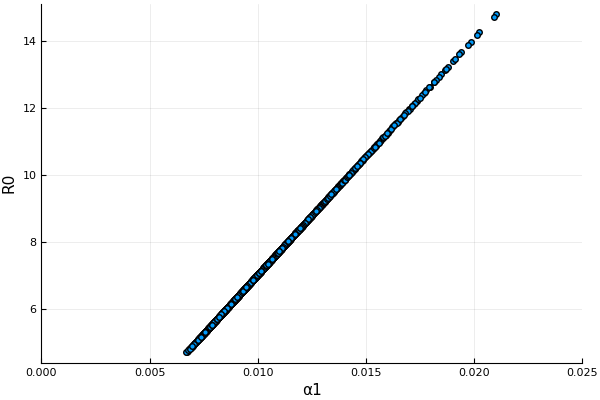

In [28]:
scatter(α1s,R0s,xlab="α1",ylab="R0",legend=false,xlim=(0,.025))


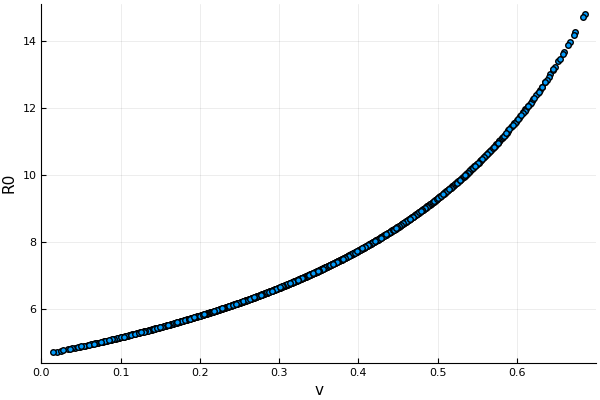

In [29]:
scatter(vs[1:nsamples],R0s,xlab="v",ylab="R0",legend=false,xlim=(0,.7))


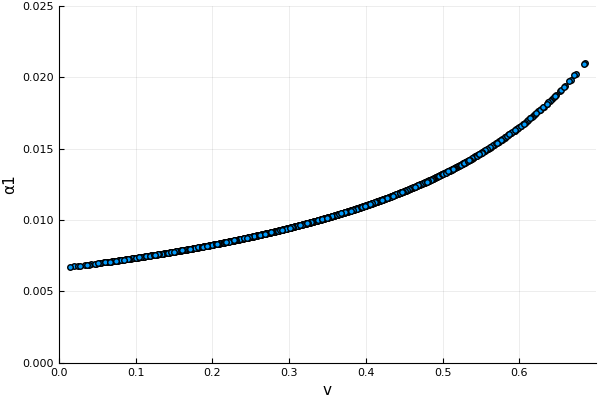

In [30]:
scatter(vs[1:nsamples],α1s,xlab="v",ylab="α1",legend=false,xlim=(0,.7),ylim=(0,.025))


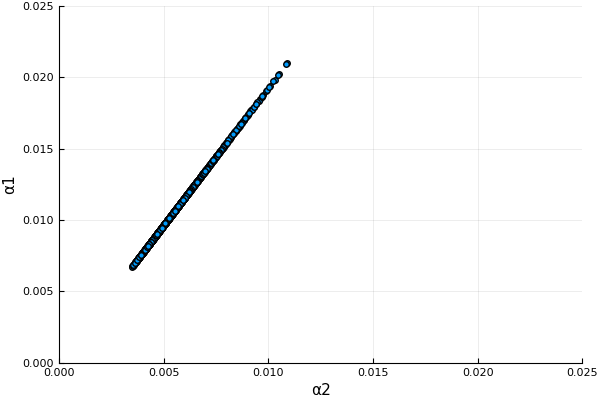

In [31]:
scatter(α2s,α1s,xlab="α2",ylab="α1",legend=false,xlim=(0,.025),ylim=(0,.025))


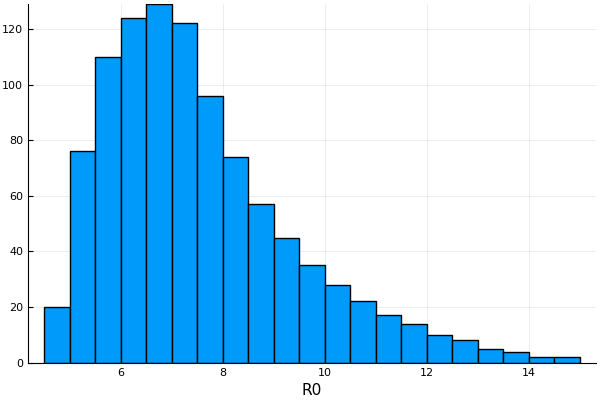

In [32]:
histogram(R0s,legend=:none,xlab="R0")


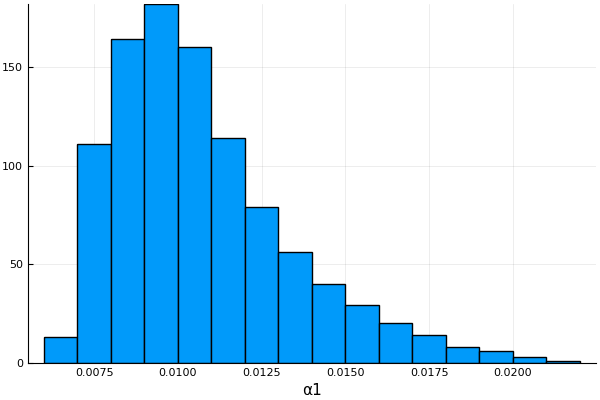

In [33]:
histogram(α1s,legend=:none,xlab="α1")


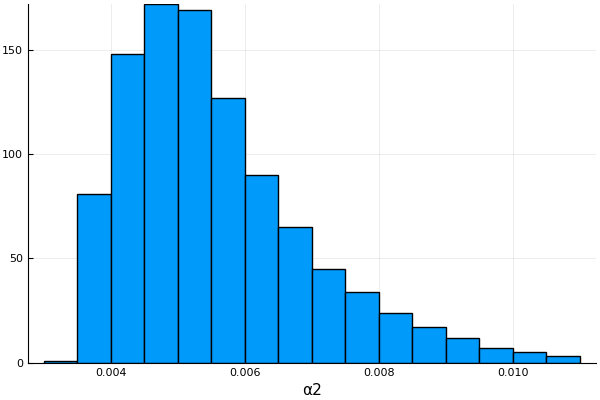

In [34]:
histogram(α2s,legend=:none,xlab="α2")

### Results: Output for plotting in R

In [35]:
writetable("output_Julia_50.csv",DataFrame(R0=R0s,a1=α1s,a2=α2s,v=vs))

# Sensitivity analysis for CV of the gen.time (Fig 4)

# mean = 8 days, CV = 25%

Distributions.Gamma{Float64}(α=16.0, θ=0.5)


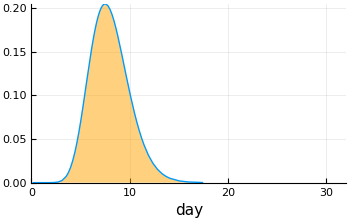

In [36]:
mean_gt = 8.0; # mean = 5 days
CV_gt = 0.25; #CV is 25% 

αgt=1/CV_gt^2; θgt = mean_gt/αgt;

gt = Gamma(αgt,θgt)
show(gt)

plot(gt, fill=(0, .5, :orange), size=(350,220), legend=false, xlim=(0,32), xlab="day")


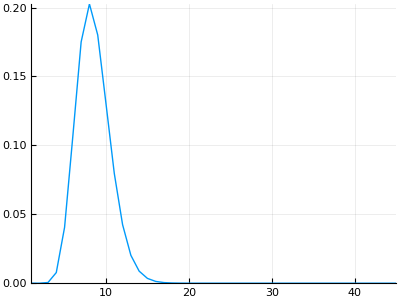

In [37]:
gen_time = (x -> cdf(gt,x)-cdf(gt,x-1)).(1:nrow(df))
plot(gen_time,size=(400,300),legend=false)

In [38]:
quantile.(gt,[.025,.5,.975])

3-element Array{Float64,1}:
  4.57269
  7.83396
 12.3701 

In [ ]:
R0s = Vector(nsamples)
α1s = Vector(nsamples)
α2s = Vector(nsamples)
initial = [.01, .01]
for k in 1:nsamples
    v = vs[k]
    println(k)
    res0 = optimize(getNegativeLoglk,log.(initial))
    res = Optim.minimizer(res0)
    α = [[exp(res[1]) for x in 1:34]; [exp(res[2]) for x in 35:kmax]]
    if (1-v-sum(df[:i]./α)/N)<=0 
        R0s[k] = -1; α1s[k] = -1; α2s[k] = -1
    else
        R0s[k] = getR0(res)
        α1s[k] = exp(res[1])
        α2s[k] = exp(res[2])
    end
end

### Results

In [40]:
dfResults = DataFrame(v = Float64.(vs), R0 = Float64.(R0s), α2 = Float64.(α2s), α1 = Float64.(α1s))
dfResults |> head

,v,R0,α2,α1
1,0.5894227250213706,14.830832768661402,0.007299017478872421,0.01898319181431099
2,0.10538829771244006,6.806535395452376,0.0033498421082325414,0.00871229613062067
3,0.43856148311409776,10.845709966334601,0.005337738674817823,0.013882325034331747
4,0.28102459847171557,8.469270813378724,0.004168171333606691,0.01084053973340195
5,0.32559869409401515,9.029042302409472,0.004443662278249169,0.01155708479137852
6,0.212055019837026,7.727957015362263,0.003803322214579971,0.009891700323493829


In [41]:
describe(dfResults)

v
Summary Stats:
Mean:           0.350003
Minimum:        0.014108
1st Quartile:   0.247769
Median:         0.349980
3rd Quartile:   0.452274
Maximum:        0.685613
Length:         1000
Type:           Float64
Number Missing: 0
% Missing:      0.000000

R0
Summary Stats:
Mean:           9.883128
Minimum:        6.176348
1st Quartile:   8.094852
Median:         9.367707
3rd Quartile:   11.117247
Maximum:        19.368472
Length:         1000
Type:           Float64
Number Missing: 0
% Missing:      0.000000

α2
Summary Stats:
Mean:           0.004864
Minimum:        0.003040
1st Quartile:   0.003984
Median:         0.004610
3rd Quartile:   0.005471
Maximum:        0.009532
Length:         1000
Type:           Float64
Number Missing: 0
% Missing:      0.000000

α1
Summary Stats:
Mean:           0.012650
Minimum:        0.007906
1st Quartile:   0.010361
Median:         0.011991
3rd Quartile:   0.014230
Maximum:        0.024791
Length:         1000
Type:           Float64
Number Missing:

In [42]:
mode(sort(dfResults,cols = [:R0])[:R0])

6.176347535689983

In [43]:
describe(sort(dfResults,cols = [:R0])[26:(end-25),:R0])

Summary Stats:
Mean:           9.777877
Minimum:        6.606941
1st Quartile:   8.157666
Median:         9.367707
3rd Quartile:   10.996969
Maximum:        16.039505
Length:         950
Type:           Float64
Number Missing: 0
% Missing:      0.000000


### Results: Plots


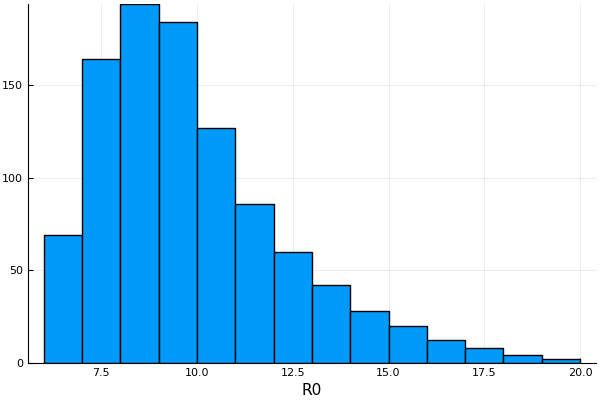

In [44]:
histogram(R0s,legend=:none,xlab="R0")

### Results: Output for plotting in R

In [45]:
writetable("output_Julia_25.csv",DataFrame(R0=R0s,a1=α1s,a2=α2s,v=vs))

# mean = 8 days, CV = 75%

Distributions.Gamma{Float64}(α=1.7777777777777777, θ=4.5)


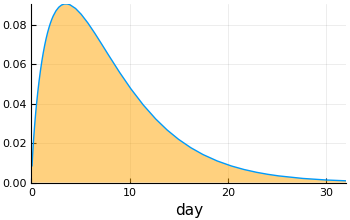

In [46]:
mean_gt = 8.0; # mean = 5 days
CV_gt = 0.75; #CV is 75% 

αgt=1/CV_gt^2; θgt = mean_gt/αgt;

gt = Gamma(αgt,θgt)
show(gt)

plot(gt, fill=(0, .5, :orange), size=(350,220), legend=false, xlim=(0,32), xlab="day")


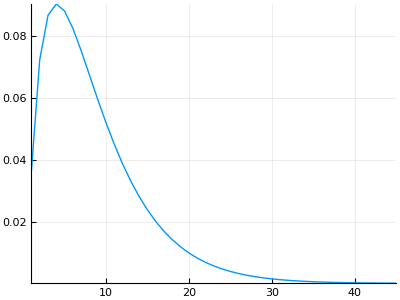

In [47]:
gen_time = (x -> cdf(gt,x)-cdf(gt,x-1)).(1:nrow(df))
plot(gen_time,size=(400,300),legend=false)

In [48]:
quantile.(gt,[.025,.5,.975])

3-element Array{Float64,1}:
  0.79649
  6.56022
 23.3133 

In [ ]:
R0s = Vector(nsamples)
α1s = Vector(nsamples)
α2s = Vector(nsamples)
initial = [.01, .01]
for k in 1:nsamples
    v = vs[k]
    println(k)
    res0 = optimize(getNegativeLoglk,log.(initial))
    res = Optim.minimizer(res0)
    α = [[exp(res[1]) for x in 1:34]; [exp(res[2]) for x in 35:kmax]]
    if (1-v-sum(df[:i]./α)/N)<=0 
        R0s[k] = -1; α1s[k] = -1; α2s[k] = -1
    else
        R0s[k] = getR0(res)
        α1s[k] = exp(res[1])
        α2s[k] = exp(res[2])
    end
end

### Results

In [50]:
dfResults = DataFrame(v = Float64.(vs), R0 = Float64.(R0s), α2 = Float64.(α2s), α1 = Float64.(α1s))
dfResults |> head

,v,R0,α2,α1
1,0.5894227250213706,8.971262436309477,0.0097584885165203,0.01438885249492456
2,0.10538829771244006,4.1173085105978275,0.00447861907355831,0.006603657486849202
3,0.43856148311409776,6.560648427733782,0.007136336579460204,0.01052243463987549
4,0.28102459847171557,5.123123291197905,0.0055726584696024085,0.008216913831927707
5,0.32559869409401515,5.4617261615206845,0.005941005695949644,0.008759921575527227
6,0.212055019837026,4.674678071276846,0.005084901400846277,0.007497664521506781


In [51]:
describe(dfResults)

v
Summary Stats:
Mean:           0.350003
Minimum:        0.014108
1st Quartile:   0.247769
Median:         0.349980
3rd Quartile:   0.452274
Maximum:        0.685613
Length:         1000
Type:           Float64
Number Missing: 0
% Missing:      0.000000

R0
Summary Stats:
Mean:           5.978367
Minimum:        3.736111
1st Quartile:   4.896624
Median:         5.666581
3rd Quartile:   6.724888
Maximum:        11.716121
Length:         1000
Type:           Float64
Number Missing: 0
% Missing:      0.000000

α2
Summary Stats:
Mean:           0.006503
Minimum:        0.004064
1st Quartile:   0.005326
Median:         0.006164
3rd Quartile:   0.007315
Maximum:        0.012744
Length:         1000
Type:           Float64
Number Missing: 0
% Missing:      0.000000

α1
Summary Stats:
Mean:           0.009589
Minimum:        0.005992
1st Quartile:   0.007854
Median:         0.009089
3rd Quartile:   0.010786
Maximum:        0.018791
Length:         1000
Type:           Float64
Number Missing: 

In [52]:
mode(sort(dfResults,cols = [:R0])[:R0])

3.7361113518279803

In [53]:
describe(sort(dfResults,cols = [:R0])[26:(end-25),:R0])

Summary Stats:
Mean:           5.914700
Minimum:        3.996596
1st Quartile:   4.934623
Median:         5.666581
3rd Quartile:   6.652141
Maximum:        9.702388
Length:         950
Type:           Float64
Number Missing: 0
% Missing:      0.000000


### Results: Plots


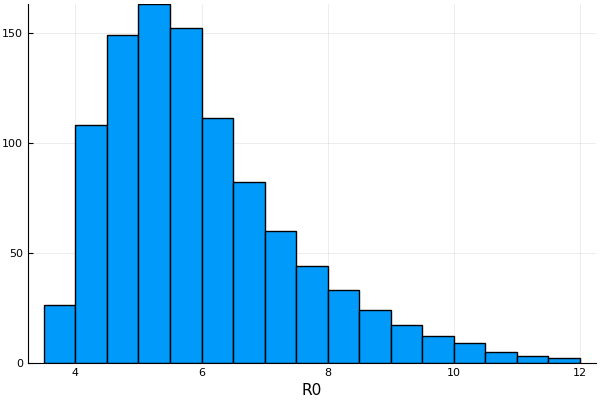

In [54]:
histogram(R0s,legend=:none,xlab="R0")

### Results: Output for plotting in R

In [55]:
writetable("output_Julia_75.csv",DataFrame(R0=R0s,a1=α1s,a2=α2s,v=vs))